<a href="https://colab.research.google.com/github/ClaraNicolini/regressoes/blob/main/Rede_Neural_v6_regmultilinear.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install category_encoders

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from google.colab import files

def mape(y_true, y_pred, eps=1e-8):
    y_true, y_pred = np.asarray(y_true), np.asarray(y_pred)
    return np.mean(np.abs((y_true - y_pred) / (y_true + eps)))

uploaded = files.upload()
filename = list(uploaded.keys())[0]
df = pd.read_csv(filename)

df['Investment per Round'] = df['Investment Amount (USD)'] / (df['Funding Rounds'] + 1)
df['Investors per Round'] = df['Number of Investors'] / (df['Funding Rounds'] + 1)
df['Is US-based'] = (df['Country'] == 'United States').astype(int)
df['Is Tech Industry'] = df['Industry'].str.contains('Tech|Software|IT|SaaS', case=False, na=False).astype(int)

df.dropna(inplace=True)

features = [
    'Funding Rounds', 'Investment Amount (USD)', 'Number of Investors',
    'Year Founded', 'Growth Rate (%)', 'Investment per Round',
    'Investors per Round', 'Is US-based', 'Is Tech Industry'
]
cat_features = ['Industry', 'Country']
target = 'Valuation (USD)'

df = df[df[target] > 0]
df['log_target'] = np.log10(df[target])
X = df[features + cat_features]
y = df['log_target']

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, features),
    ('cat', categorical_transformer, cat_features)
], remainder='drop')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

preprocessor.fit(X_train)
X_train_tf = preprocessor.transform(X_train)
X_test_tf = preprocessor.transform(X_test)

model_tf = Sequential([
    Dense(50, activation='relu', input_shape=(X_train_tf.shape[1],)),
    Dense(1)
])

model_tf.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mean_squared_error',
    metrics=['mae']
)

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model_tf.fit(
    X_train_tf, y_train,
    validation_split=0.2,
    epochs=500,
    batch_size=32,
    callbacks=[early_stop],
    verbose=0
)

y_pred_log_tf = model_tf.predict(X_test_tf).flatten()
y_pred_tf = 10 ** y_pred_log_tf
y_test_real = 10 ** y_test

mae_tf  = mean_absolute_error(y_test_real, y_pred_tf)
rmse_tf = np.sqrt(mean_squared_error(y_test_real, y_pred_tf))
mape_tf = mape(y_test_real, y_pred_tf)
r2_tf   = r2_score(y_test_real, y_pred_tf)

print("=== Modelo TensorFlow ===")
print(f"MAE  : {mae_tf:,.0f}")
print(f"RMSE : {rmse_tf:,.0f}")
print(f"MAPE : {mape_tf*100:.2f}%")
print(f"R²   : {r2_tf:.3f}")


Saving startup_growth_investment_data.csv to startup_growth_investment_data (3).csv


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
=== Modelo TensorFlow ===
MAE  : 2,428,087,036
RMSE : 3,351,449,296
MAPE : 47.46%
R²   : 0.612


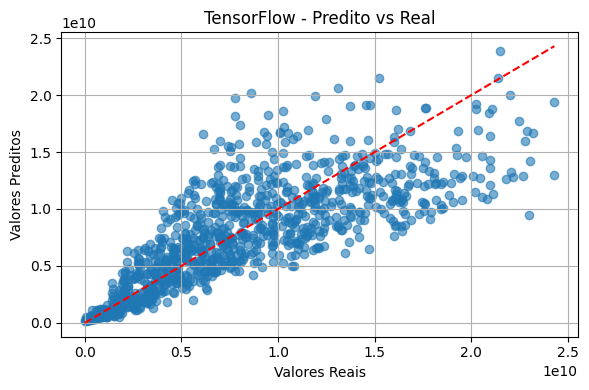

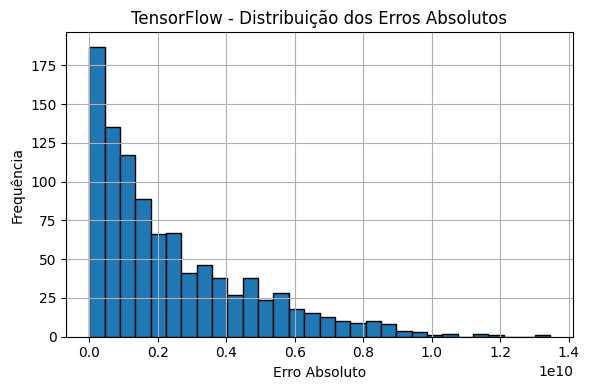

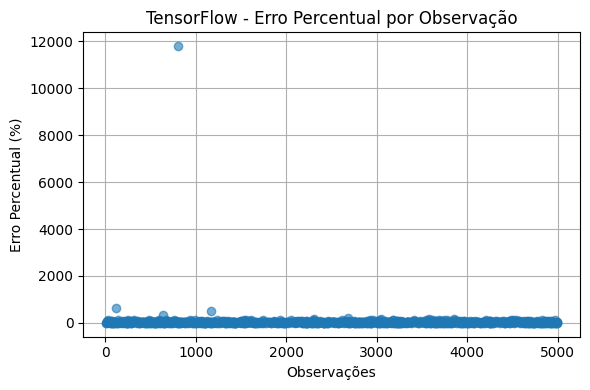

In [ ]:
errors = y_test_real - y_pred_tf
abs_errors = np.abs(errors)
percent_errors = 100 * abs_errors / (y_test_real + 1e-8)
erro_rel = abs_errors / (y_test_real + 1e-8)

plt.figure(figsize=(6, 4))
plt.scatter(y_test_real, y_pred_tf, alpha=0.6)
plt.plot([min(y_test_real), max(y_test_real)],
         [min(y_test_real), max(y_test_real)],
         color='red', linestyle='--')
plt.xlabel('Valores Reais')
plt.ylabel('Valores Preditos')
plt.title('TensorFlow - Predito vs Real')
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.hist(abs_errors, bins=30, edgecolor='black')
plt.xlabel('Erro Absoluto')
plt.ylabel('Frequência')
plt.title('TensorFlow - Distribuição dos Erros Absolutos')
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(percent_errors, marker='o', linestyle='', alpha=0.6)
plt.xlabel('Observações')
plt.ylabel('Erro Percentual (%)')
plt.title('TensorFlow - Erro Percentual por Observação')
plt.grid(True)
plt.tight_layout()
plt.show()
